In [1]:
import numpy as np
from scipy.stats import norm
from scipy.misc import imsave
import matplotlib.pyplot as plt
import cv2
import os
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from numpy import genfromtxt

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [82]:
temp = genfromtxt(fname = '/Users/ckruse/Downloads/Old_Faithful_Logger.tsv', delimiter = '	')
time = temp[1:-1,0]
temp = temp[1:-1,1]
np.shape(temp)

(282084,)

In [83]:
#Normalize deltas between -1 and 1

print(np.max(temp))

temp = temp/np.max(temp)*2 - 1
print(np.max(temp))

58.153888888889
1.0


In [84]:
def create_dataset(dataset, look_back):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back)]
		dataX.append(a)
		dataY.append(dataset[i + look_back])
	return np.array(dataX), np.array(dataY)

(281933, 150)


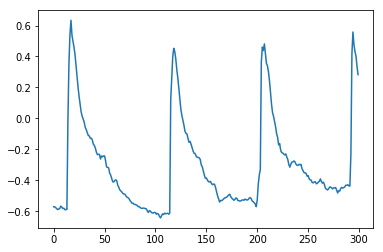

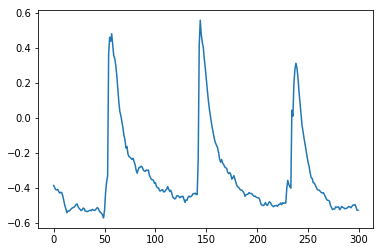

(281933, 150, 1)
(281933,)


In [101]:
X, Y = create_dataset(temp, 150)

print(X.shape)
plt.plot(X[0:300,0])
plt.show()
plt.plot(Y[0:300])
plt.show()
X = X.reshape(X.shape[0], X.shape[1], 1)
Y = Y.reshape(Y.shape[0])

print(X.shape)
print(Y.shape)


In [108]:
from keras.layers import Conv1D, Dense, MaxPooling1D, Flatten

model = Sequential()

#model.add(Conv1D(filters=8, kernel_size=4, activation='relu', input_shape=(150,1), strides=1))
#model.add(Conv1D(filters=16, kernel_size=4, activation='relu', strides=1))
model.add(Flatten())
model.add(Dense(150, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


model.compile(loss=keras.losses.mean_squared_error,
              optimizer=keras.optimizers.Adam(),
              metrics=['mse'])



Train on 253739 samples, validate on 28194 samples
Epoch 1/5
253739/253739 [==============================] - 4s 15us/step - loss: 0.1485 - mean_squared_error: 0.1485 - val_loss: 0.2011 - val_mean_squared_error: 0.2011
Epoch 2/5
253739/253739 [==============================] - 3s 10us/step - loss: 0.1385 - mean_squared_error: 0.1385 - val_loss: 0.2003 - val_mean_squared_error: 0.2003
Epoch 3/5
253739/253739 [==============================] - 3s 10us/step - loss: 0.1385 - mean_squared_error: 0.1385 - val_loss: 0.2004 - val_mean_squared_error: 0.2004
Epoch 4/5
253739/253739 [==============================] - 3s 10us/step - loss: 0.1384 - mean_squared_error: 0.1384 - val_loss: 0.2003 - val_mean_squared_error: 0.2003
Epoch 5/5
253739/253739 [==============================] - 3s 10us/step - loss: 0.1384 - mean_squar

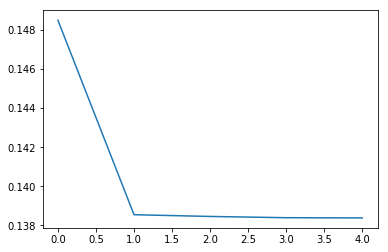

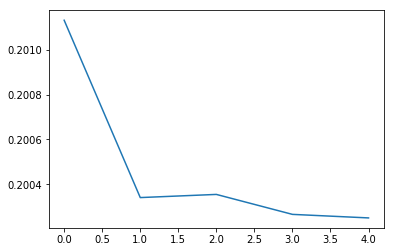

In [109]:
from keras.models import load_model

epochs = 5

#model = load_model('/Users/ckruse/Documents/python/oldFaithfulTemp.h5')
history = 0
history = model.fit(X,
                    Y,
                    epochs=epochs,
                    verbose=1,
                    batch_size=256,
                    validation_split=0.1,
                    shuffle=True)

model.save('/Users/ckruse/Documents/python/oldFaithfulTemp.h5')
plt.plot(history.history['loss'])
plt.show()

plt.plot(history.history['val_loss'])
plt.show()

#score = model.evaluate(data_stack, label_stack, verbose=1)
#print('Test loss:', score[0])
#print('Test accuracy:', score[1])
#model.save('/Users/ckruse/Documents/python/soccer/model.h5')

In [110]:
trainPredict = model.predict(X[])

In [111]:
print(trainPredict)
print(Y)

[[1.0436212e-10]
 [1.5604819e-10]
 [6.3342304e-11]
 ...
 [2.0427189e-10]
 [1.3493773e-10]
 [1.1346437e-10]]
[-0.38551926 -0.39780468 -0.40924941 ... -0.64928303 -0.64928303
 -0.6509644 ]
